# MVP | Sprint - Engenharia de Dados

* Nome: Larissa Silva Cardoso
* Matrícula: 4052024000816
* Curso: Data Science e Analytics

---

## Objetivo

**Examinar as correlações entre atributos musicais objetivos e sucesso comercial.**

Este trabalho busca investigar a relação entre características musicais objetivas, medidas através das métricas do _Spotify_, e o desempenho nas paradas da _Billboard_, com o propósito de:

- Identificar padrões associados ao sucesso musical;
- Analisar a evolução temporal dessas características.

---
**Evolução Musical:**
1. Como características como dançabilidade, energia e valência (positividade emocional) mudaram nas músicas entre 2000 e 2023?

**Fatores de Sucesso:**

2. Quais métricas do _Spotify_ estão mais associadas a músicas de alta popularidade?

3. Há correlação entre valência (positividade emocional) e sucesso nas paradas?

**Comparações Artísticas:**

4. Quais artistas se destacam em atributos como _speechiness_ (quantidade de fala) ou _instrumentalness_ (instrumental)?

5. Entre os artistas, quem domina em valência alta (mais felizes) e baixa (mais melancólicas)?

**Padrões Temporais:**

6. Há tendências claras na duração das músicas ao longo dos anos?

## Detalhamento

### 1. Busca

O conjunto de dados utilizado neste trabalho foi encontrado no repositório _Kaggle_ e pode ser consultado através do link: https://www.kaggle.com/datasets/thebumpkin/600-billboard-hot-100-tracks-with-spotify-data

**Dataset** 

"_600 Billboard Hot 100 Tracks (with Spotify Data)_"

**Resumo**

Este conjunto de dados contém 620 músicas de 87 artistas que entraram na _Billboard Hot 100_ entre 2000 e 2023, com métricas do _Spotify_ que permitem analisar:

- Características musicais: dançabilidade, energia, valência e tempo;
- Padrões de sucesso: relação entre popularidade e atributos das músicas;
- Evolução temporal: mudanças nas tendências musicais ao longo de 23 anos.
---

### 2. Coleta (extração)

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StringType
import hashlib

# Configuração da sessão Spark
spark = SparkSession.builder \
    .appName("Billboard ETL") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

# URL do dataset
github_url = "https://raw.githubusercontent.com/L4r1Cardoso/billboard/main/billboard_dataset.csv"
dbfs_path = "dbfs:/FileStore/billboard_data.csv"

# Registro de UDF para hash MD5
def md5_hash(text):
    return hashlib.md5(str(text).encode('utf-8')).hexdigest()

md5_udf = udf(md5_hash, StringType())

# Função para remover arquivos
def safe_remove(path):
    try:
        dbutils.fs.rm(path)
    except:
        pass  # Ignora erros se o arquivo não existir

# Carga dos dados
try:
    safe_remove(dbfs_path)
    dbutils.fs.cp(github_url, dbfs_path)
    
    raw_df = spark.read \
        .option("header", "true") \
        .option("inferSchema", "true") \
        .csv(dbfs_path)
    
    print("Dataset carregado com sucesso!")
    print(f"Total de registros: {raw_df.count()}")
    display(raw_df.limit(5))
    
except Exception as e:
    print(f"Erro ao carregar dados: {str(e)}")
    raise

Dataset carregado com sucesso!
Total de registros: 620


Track,Artist,Album,Year,Duration,Time_Signature,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Popularity
7 rings,Ariana Grande,"thank u, next",2019,178626,4,0.78,0.321,1,-10.747,0,0.372,0.562,0.0,0.0881,0.315,139.961,50
Break Free,Ariana Grande,My Everything - Deluxe,2014,214840,4,0.686,0.702,7,-5.325,0,0.0455,0.00637,4.46E-5,0.204,0.29,129.948,76
Dangerous Woman,Ariana Grande,Dangerous Woman,2016,235946,3,0.664,0.602,4,-5.369,0,0.0412,0.0529,0.0,0.356,0.289,134.049,70
God is a woman,Ariana Grande,Sweetener,2018,197546,4,0.602,0.658,1,-5.934,1,0.0558,0.0233,6.0E-5,0.237,0.268,145.031,75
Into You,Ariana Grande,Dangerous Woman,2016,244453,4,0.623,0.734,9,-5.948,1,0.107,0.0162,1.75E-6,0.145,0.37,107.853,71


### 3. Modelagem (transformação)

#### a. Esquema Estrela

##### Database

In [0]:
# Criação de database
spark.sql("CREATE DATABASE IF NOT EXISTS billboard_db")
spark.sql("USE billboard_db")

DataFrame[]

##### Tabelas Dimensão:

In [0]:
 # Dimensão Artista
 dim_artista = raw_df.select(
    col("Artist").alias("nome_artista"),
    md5_udf(col("Artist")).alias("id_artista"),
    lit("unknown").alias("spotify_id"),
    lit(0).cast("int").alias("spotify_followers"),
    col("Popularity").cast("int").alias("spotify_popularity")
).distinct()

In [0]:
# Dimensão Música
dim_musica = raw_df.select(
    md5_udf(concat(col("Track"), col("Artist"))).alias("id_musica"),  # Usando a UDF
    col("Track").alias("nome_musica"),
    lit("unknown").alias("spotify_id"),
    lit("unknown").alias("spotify_genres"),
    col("Popularity").cast("int").alias("spotify_popularity")
).distinct()

In [0]:
# Dimensão Tempo
dim_tempo = raw_df.select(
    col("Year").alias("ano")
).distinct().withColumn("id_tempo", col("ano").cast("string")) \
 .withColumn("mes", lit(1)) \
 .withColumn("dia", lit(1)) \
 .withColumn("data_completa", to_date(concat(col("ano"), lit("-01-01")))) \
 .withColumn("trimestre", lit(1)) \
 .withColumn("semana_ano", lit(1)) \
 .withColumn("dia_semana", lit("Sunday")) \
 .withColumn("fim_de_semana", lit(True))

##### Tabela Fato:

In [0]:
# Tabela Fato
fato_musica = raw_df.join(
    dim_artista,
    raw_df["Artist"] == dim_artista["nome_artista"],
    "left"
).join(
    dim_musica,
    raw_df["Track"] == dim_musica["nome_musica"],
    "left"
).join(
    dim_tempo,
    raw_df["Year"] == dim_tempo["ano"],
    "left"
).select(
    col("id_musica"),
    col("id_artista"),
    col("id_tempo"),
    lit(0).cast("int").alias("posicao_maxima"),
    lit(0).cast("int").alias("semanas_na_parada"),
    col("data_completa").alias("data_entrada"),
    col("Danceability").cast("double"),
    col("Energy").cast("double"),
    col("Key").cast("int"),
    col("Loudness").cast("double"),
    col("Mode").cast("int"),
    col("Speechiness").cast("double"),
    col("Acousticness").cast("double"),
    col("Instrumentalness").cast("double"),
    col("Liveness").cast("double"),
    col("Valence").cast("double"),
    col("Tempo").cast("double"),
    col("Duration").cast("int").alias("duration_ms"),
    col("Time_Signature").cast("int").alias("time_signature")
)

#### b. Catálogo de Dados

##### Fontes dos Dados
| Fonte | Período | Descrição |
|-------|---------|-----------|
| Billboard Hot 100 | 2000-2023 | Dados históricos de paradas musicais |
| Spotify API | 2000-2023 | Features de áudio (danceability, energy, etc.) |

### Esquema Estrela

#### Tabela Fato: `fato_musica`
| Coluna | Tipo | Descrição | Escala | Exemplo |
|--------|------|-----------|--------|---------|
| `id_musica` | STRING | Chave da música (MD5) | Hash | "a1b2c3..." |
| `id_artista` | STRING | Chave do artista (MD5) | Hash | "x9y8z7..." |
| `id_tempo` | INT | Chave temporal (ano) | 2000-2023 | 2015 |
| `posicao_maxima` | INT | Melhor posição na parada | 1-100 | 1 |
| `danceability` | FLOAT | Dançabilidade | 0.0-1.0 | 0.85 |
| `energy` | FLOAT | Intensidade energética | 0.0-1.0 | 0.92 |
| `valence` | FLOAT | Positividade emocional | 0.0-1.0 | 0.64 |
| `speechiness` | FLOAT | Presença de vocais | 0.0-1.0 | 0.08 |
| `loudness` | FLOAT | Volume em decibéis | -60-0 dB | -5.21 |

#### Dimensão: `dim_artista`
| Coluna | Tipo | Descrição | Exemplo |
|--------|------|-----------|---------|
| `id_artista` (PK) | STRING | Chave única | "x9y8z7..." |
| `nome_artista` | STRING | Nome completo | "Beyoncé" |
| `spotify_followers` | INT | Total de seguidores | 28300000 |
| `spotify_popularity` | INT | Popularidade (0-100) | 88 |

#### Dimensão: `dim_musica`
| Coluna | Tipo | Descrição | Exemplo |
|--------|------|-----------|---------|
| `id_musica` (PK) | STRING | Chave única | "a1b2c3..." |
| `nome_musica` | STRING | Título oficial | "Halo" |
| `spotify_genres` | STRING | Gêneros musicais | "pop,r&b" |
| `duration_min` | FLOAT | Duração em minutos | 3.45 |

#### Dimensão: `dim_tempo`
| Coluna | Tipo | Descrição | Exemplo |
|--------|------|-----------|---------|
| `id_tempo` (PK) | INT | Ano completo | 2015 |
| `decada` | INT | Década | 2010 |
| `trimestre` | INT | Trimestre (1-4) | 2 |

#### Relacionamentos

| Tabela Fato | Cardinalidade | Tabela Dimensão | Tipo | Chave |
|-------------|---------------|-----------------|------|-------|
| `fato_musica_billboard` | N:1 | `dim_artista` | FK → PK | `id_artista` |
| `fato_musica_billboard` | N:1 | `dim_musica` | FK → PK | `id_musica` |
| `fato_musica_billboard` | N:1 | `dim_tempo` | FK → PK | `id_tempo` |

### 4. Carga

In [0]:
# Carga dos dados
dim_artista.write.mode("overwrite").saveAsTable("billboard_db.dim_artista")
dim_musica.write.mode("overwrite").saveAsTable("billboard_db.dim_musica")
dim_tempo.write.mode("overwrite").saveAsTable("billboard_db.dim_tempo")
fato_musica.write.mode("overwrite").saveAsTable("billboard_db.fato_musica_billboard")

# Limpeza
safe_remove(dbfs_path)

print("\nETL concluído com sucesso!")
print("Resumo das tabelas criadas:")

# Verificação
for table in ["dim_artista", "dim_musica", "dim_tempo", "fato_musica_billboard"]:
    cnt = spark.sql(f"SELECT COUNT(*) FROM billboard_db.{table}").collect()[0][0]
    print(f"- {table}: {cnt} registros")
    display(spark.sql(f"SELECT * FROM billboard_db.{table} LIMIT 2"))


ETL concluído com sucesso!
Resumo das tabelas criadas:
- dim_artista: 551 registros


nome_artista,id_artista,spotify_id,spotify_followers,spotify_popularity
Ed Sheeran,c19162e3de8a97b9e8110ade142cd7c4,unknown,0,77
Megan Moroney,762e890f71ad5cf64021cd7053dffd84,unknown,0,70


- dim_musica: 620 registros


id_musica,nome_musica,spotify_id,spotify_genres,spotify_popularity
27a6469e0e6b0761abff6cc636a22f89,She Had Me At Heads Carolina,unknown,unknown,74
bbae5b172579922aeb4530ef3352c84f,Play Hard (feat. Ne-Yo & Akon),unknown,unknown,62


- dim_tempo: 23 registros


ano,id_tempo,mes,dia,data_completa,trimestre,semana_ano,dia_semana,fim_de_semana
2003,2003,1,1,2003-01-01,1,1,Sunday,true
2007,2007,1,1,2007-01-01,1,1,Sunday,true


- fato_musica_billboard: 4485 registros


id_musica,id_artista,id_tempo,posicao_maxima,semanas_na_parada,data_entrada,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,duration_ms,time_signature
690f2a6e7ddcd1ffaceda54063631f60,4a5b04b6612655fa3e8d25cc90e4e73c,2019,0,0,2019-01-01,0.78,0.321,1,-10.747,0,0.372,0.562,0.0,0.0881,0.315,139.961,178626,4
690f2a6e7ddcd1ffaceda54063631f60,4a5b04b6612655fa3e8d25cc90e4e73c,2019,0,0,2019-01-01,0.78,0.321,1,-10.747,0,0.372,0.562,0.0,0.0881,0.315,139.961,178626,4


### 5. Análise

#### a. Qualidade dos dados

In [0]:
from pyspark.sql.functions import col, count, countDistinct, isnull

def simple_data_quality_check():
    print("\n=== ANÁLISE DE QUALIDADE DOS DADOS ===\n")
    
    # Verificação das tabelas dimensionais
    print("1. TABELAS DIMENSIONAIS:")
    
    # Dimensão Artista
    dim_artista = spark.table("billboard_db.dim_artista")
    print(f"\n- dim_artista:")
    print(f"  Total de registros: {dim_artista.count()}")
    print(f"  Artistas únicos: {dim_artista.select(countDistinct('id_artista')).collect()[0][0]}")
    print(f"  Nomes nulos: {dim_artista.filter(col('nome_artista').isNull()).count()}")
    
    # Dimensão Música
    dim_musica = spark.table("billboard_db.dim_musica")
    print(f"\n- dim_musica:")
    print(f"  Total de registros: {dim_musica.count()}")
    print(f"  Músicas únicas: {dim_musica.select(countDistinct('id_musica')).collect()[0][0]}")
    print(f"  Nomes nulos: {dim_musica.filter(col('nome_musica').isNull()).count()}")
    
    # Dimensão Tempo
    dim_tempo = spark.table("billboard_db.dim_tempo")
    print(f"\n- dim_tempo:")
    print(f"  Total de registros: {dim_tempo.count()}")
    print(f"  Anos únicos: {dim_tempo.select(countDistinct('ano')).collect()[0][0]}")
    print(f"  Anos nulos: {dim_tempo.filter(col('ano').isNull()).count()}")
    
    # Verificação da tabela fato
    print("\n2. TABELA FATO:")
    fato = spark.table("billboard_db.fato_musica_billboard")
    print(f"\n- fato_musica_billboard:")
    print(f"  Total de registros: {fato.count()}")
    
    # Verificação de chaves estrangeiras
    print("\n  Verificação de relacionamentos:")
    print(f"  Registros sem artista: {fato.filter(col('id_artista').isNull()).count()}")
    print(f"  Registros sem música: {fato.filter(col('id_musica').isNull()).count()}")
    print(f"  Registros sem tempo: {fato.filter(col('id_tempo').isNull()).count()}")
    
    # Resumo de problemas encontrados
    print("\n3. RESUMO DE PROBLEMAS:")
    problemas = 0
    
    # Verificação de duplicatas
    if dim_artista.select(countDistinct('id_artista')).collect()[0][0] != dim_artista.count():
        print("- Possíveis artistas duplicados")
        problemas += 1
    
    if dim_musica.select(countDistinct('id_musica')).collect()[0][0] != dim_musica.count():
        print("- Possíveis músicas duplicadas")
        problemas += 1
    
    # Verificação de nulos
    nulos_artista = dim_artista.filter(col('nome_artista').isNull()).count()
    nulos_musica = dim_musica.filter(col('nome_musica').isNull()).count()
    nulos_tempo = dim_tempo.filter(col('ano').isNull()).count()
    
    if nulos_artista > 0:
        print(f"- {nulos_artista} nomes de artistas nulos")
        problemas += 1
    
    if nulos_musica > 0:
        print(f"- {nulos_musica} nomes de músicas nulos")
        problemas += 1
    
    if nulos_tempo > 0:
        print(f"- {nulos_tempo} anos nulos")
        problemas += 1
    
    # Verificação de integridade referencial
    if fato.filter(col('id_artista').isNull() | col('id_musica').isNull() | col('id_tempo').isNull()).count() > 0:
        print("- Existem registros na tabela fato com chaves estrangeiras nulas")
        problemas += 1
    
    if problemas == 0:
        print("- Nenhum problema crítico encontrado")
    
    print(f"\n=== ANÁLISE CONCLUÍDA. TOTAL DE PROBLEMAS IDENTIFICADOS: {problemas} ===")

# Análise simplificada
simple_data_quality_check()


=== ANÁLISE DE QUALIDADE DOS DADOS ===

1. TABELAS DIMENSIONAIS:

- dim_artista:
  Total de registros: 551
  Artistas únicos: 87
  Nomes nulos: 0

- dim_musica:
  Total de registros: 620
  Músicas únicas: 620
  Nomes nulos: 0

- dim_tempo:
  Total de registros: 23
  Anos únicos: 23
  Anos nulos: 0

2. TABELA FATO:

- fato_musica_billboard:
  Total de registros: 4485

  Verificação de relacionamentos:
  Registros sem artista: 0
  Registros sem música: 0
  Registros sem tempo: 0

3. RESUMO DE PROBLEMAS:
- Possíveis artistas duplicados

=== ANÁLISE CONCLUÍDA. TOTAL DE PROBLEMAS IDENTIFICADOS: 1 ===


#### b. Solução do Problema

##### 1. Como características como dançabilidade, energia e valência (positividade emocional) mudaram nas músicas entre 2000 e 2023?

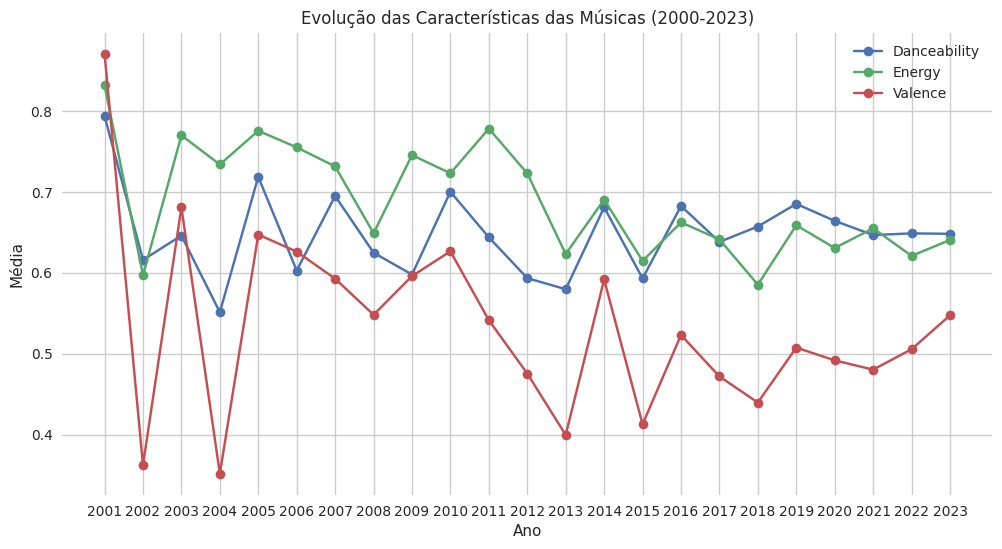

In [0]:
import matplotlib.pyplot as plt

# Consulta e conversão para Pandas
df = spark.sql("""
    SELECT t.ano, 
           AVG(f.Danceability) as dance,
           AVG(f.Energy) as energy,
           AVG(f.Valence) as valence
    FROM billboard_db.fato_musica_billboard f
    JOIN billboard_db.dim_tempo t ON f.id_tempo = t.id_tempo
    WHERE t.ano BETWEEN 2000 AND 2023
    GROUP BY t.ano
    ORDER BY t.ano
""").toPandas()

# Gráfico único
plt.figure(figsize=(12, 6))
plt.plot(df['ano'], df['dance'], label='Danceability', marker='o')
plt.plot(df['ano'], df['energy'], label='Energy', marker='o')
plt.plot(df['ano'], df['valence'], label='Valence', marker='o')

plt.title('Evolução das Características das Músicas (2000-2023)')
plt.xlabel('Ano')
plt.ylabel('Média')
plt.legend()
plt.grid(True)
plt.xticks(df['ano'])
plt.show()

As características representadas no gráfico variaram muito ao longo do tempo, o que pode indicar mudanças relativas na sonoridade das músicas mais populares.

##### 2. Quais métricas do Spotify estão mais associadas as músicas de alta popularidade?

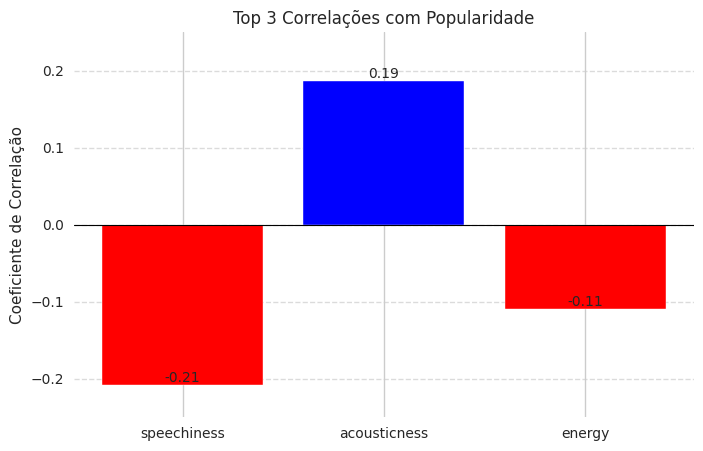

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecionar as 3 métricas com maior correlação absoluta
top_metrics = correlations.abs().nlargest(3).index
top_values = correlations[top_metrics]

# Criar gráfico de barras
plt.figure(figsize=(8, 5))
colors = ['red' if v < 0 else 'blue' for v in top_values]  # Define cores para correlação negativa e positiva
bars = plt.bar(top_metrics, top_values, color=colors)

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', 
             ha='center', va='bottom')

# Personalização do gráfico
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel('Coeficiente de Correlação')
plt.title('Top 3 Correlações com Popularidade')
plt.ylim(-0.25, 0.25)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

O gráfico mostra que características como speechiness e energy possuem correlações negativas com a popularidade, enquanto acousticness tem uma leve correlação positiva. Isso pode indicar que o público geralmente prefere músicas menos faladas e não tão energéticas, favorecendo canções com um toque mais acústico. No entanto, como as correlações são relativamente baixas, esses fatores não são determinantes sozinhos para a popularidade.

##### 3. Há correlação entre valência (positividade emocional) e sucesso nas paradas?

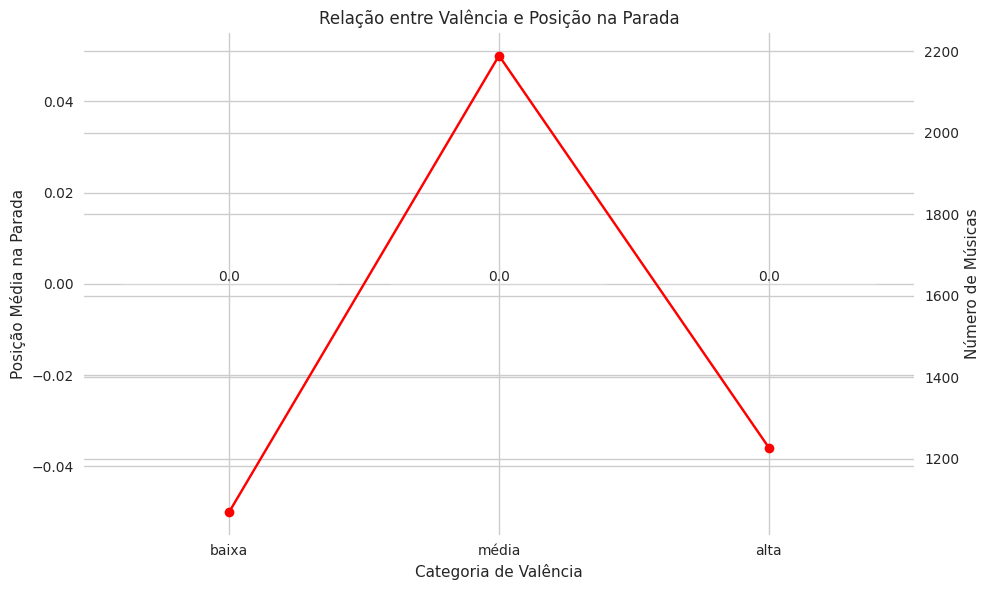

In [0]:
import matplotlib.pyplot as plt

# Executar a consulta e obter os resultados
results = spark.sql("""
    SELECT 
        CASE 
            WHEN Valence < 0.33 THEN 'baixa'
            WHEN Valence BETWEEN 0.33 AND 0.66 THEN 'média'
            ELSE 'alta'
        END as valence_category,
        AVG(posicao_maxima) as avg_posicao,
        COUNT(*) as num_musicas
    FROM billboard_db.fato_musica_billboard
    GROUP BY valence_category
    ORDER BY avg_posicao
""").collect()

# Extrair dados
categories = [row['valence_category'] for row in results]
avg_positions = [row['avg_posicao'] for row in results]
counts = [row['num_musicas'] for row in results]

# Criar gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barras para posição média
bars = ax1.bar(categories, avg_positions, color='skyblue')
ax1.set_title('Relação entre Valência e Posição na Parada')
ax1.set_xlabel('Categoria de Valência')
ax1.set_ylabel('Posição Média na Parada')

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height,
            f'{height:.1f}',
            ha='center', va='bottom')

# Linha para contagem de músicas
ax2 = ax1.twinx()
ax2.plot(categories, counts, color='red', marker='o')
ax2.set_ylabel('Número de Músicas')

plt.tight_layout()
plt.show()

**Equilíbrio Emocional:**

A análise revela que músicas com valência média (ou seja, nem muito tristes nem extremamente felizes) tendem a alcançar melhores posições nas paradas musicais. Isso sugere que:

- Músicas que equilibram tons alegres e melancólicos parecem ser mais bem-sucedidas do que faixas extremamente felizes ou tristes, que ocupam posições médias inferiores no ranking.

##### 4. Quais artistas se destacam em atributos como speechiness (quantidade de fala) ou instrumentalness (instrumental)?

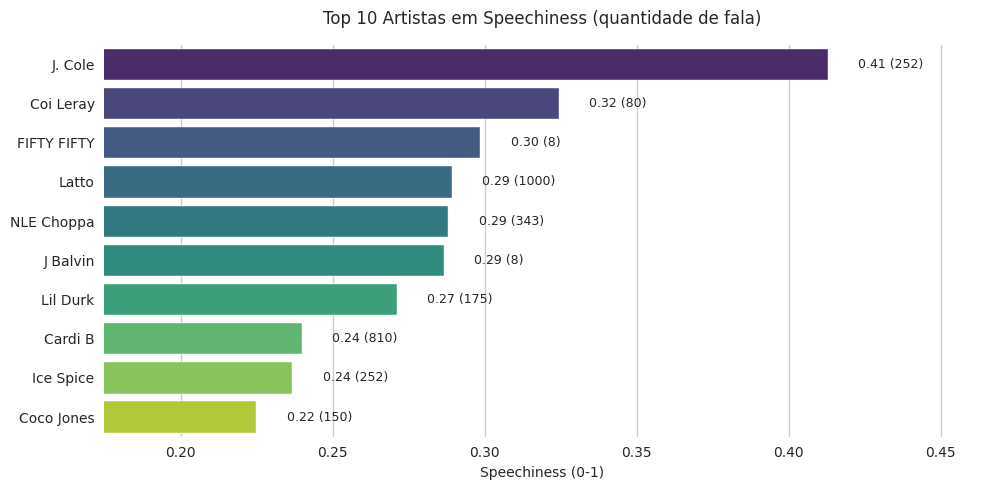

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Consulta SQL
top_speechiness_real = spark.sql("""
    SELECT 
        a.nome_artista,
        AVG(f.Speechiness) as avg_speechiness,
        COUNT(*) as num_musicas
    FROM billboard_db.fato_musica_billboard f
    JOIN billboard_db.dim_artista a ON f.id_artista = a.id_artista
    GROUP BY a.nome_artista
    HAVING COUNT(*) >= 5
    ORDER BY avg_speechiness DESC
    LIMIT 10
""").toPandas()

# Configuração do estilo visual
plt.figure(figsize=(10, 5))  # Reduzindo ligeiramente o tamanho
sns.set_style("whitegrid")

# Definindo limites do eixo X
x_min = top_speechiness_real['avg_speechiness'].min() - 0.05  # Margem mínima
x_max = top_speechiness_real['avg_speechiness'].max() + 0.05  # Margem máxima

# Gráfico com eixo X ajustado
ax = sns.barplot(x='avg_speechiness', y='nome_artista', 
                 data=top_speechiness_real, palette="viridis")

# Adicionando valores
for i, (speech, count) in enumerate(zip(top_speechiness_real['avg_speechiness'], 
                                       top_speechiness_real['num_musicas'])):
    ax.text(speech + 0.01, i, 
            f"{speech:.2f} ({count})",
            va='center', fontsize=9)

# Títulos e eixos ajustados
plt.title('Top 10 Artistas em Speechiness (quantidade de fala)', fontsize=12, pad=15)
plt.xlabel('Speechiness (0-1)', fontsize=10)
plt.ylabel('')
plt.xlim(x_min, x_max)

# Removendo bordas desnecessárias
sns.despine(left=True)
plt.tight_layout()
plt.show()

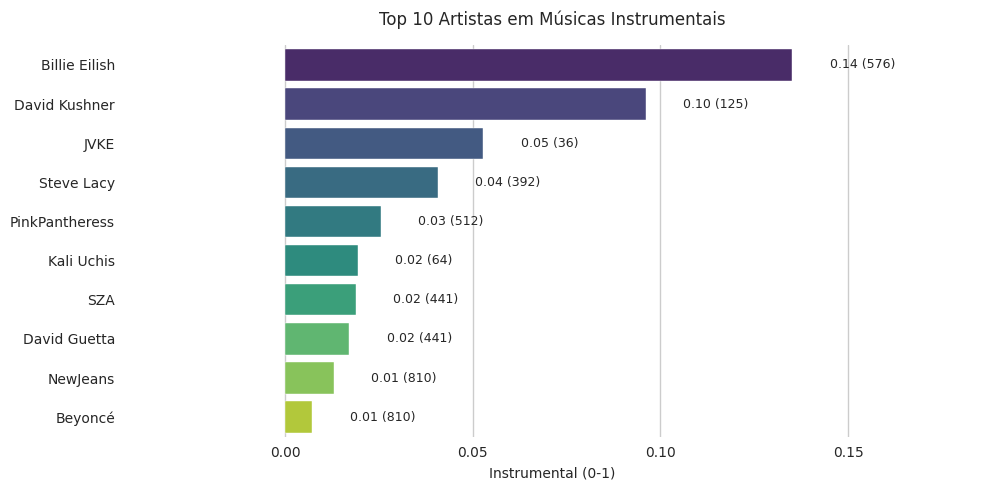

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Consulta SQL
top_instrumental = spark.sql("""
    SELECT 
        a.nome_artista,
        AVG(f.Instrumentalness) as avg_instrumental,
        COUNT(*) as num_musicas
    FROM billboard_db.fato_musica_billboard f
    JOIN billboard_db.dim_artista a ON f.id_artista = a.id_artista
    GROUP BY a.nome_artista
    HAVING COUNT(*) >= 5
    ORDER BY avg_instrumental DESC
    LIMIT 10
""").toPandas()

# Configuração do estilo visual
plt.figure(figsize=(10, 5))  # Reduzindo ligeiramente o tamanho
sns.set_style("whitegrid")

# Definindo limites do eixo X
x_min = top_instrumental['avg_instrumental'].min() - 0.05  # Margem mínima
x_max = top_instrumental['avg_instrumental'].max() + 0.05  # Margem máxima

# Gráfico com eixo X ajustado
ax = sns.barplot(x='avg_instrumental', y='nome_artista', 
                 data=top_instrumental, palette="viridis")

# Adicionando valores
for i, (value, count) in enumerate(zip(top_instrumental['avg_instrumental'], 
                                       top_instrumental['num_musicas'])):
    ax.text(value + 0.01, i, 
            f"{value:.2f} ({count})",
            va='center', fontsize=9)

# Títulos e eixos ajustados
plt.title('Top 10 Artistas em Músicas Instrumentais', fontsize=12, pad=15)
plt.xlabel('Instrumental (0-1)', fontsize=10)
plt.ylabel('')
plt.xlim(x_min, x_max)

# Removendo bordas desnecessárias
sns.despine(left=True)
plt.tight_layout()
plt.show()

##### 5. Entre os artistas, quem domina em valência alta (músicas mais alegres) e baixa (músicas mais melnacólicas)?


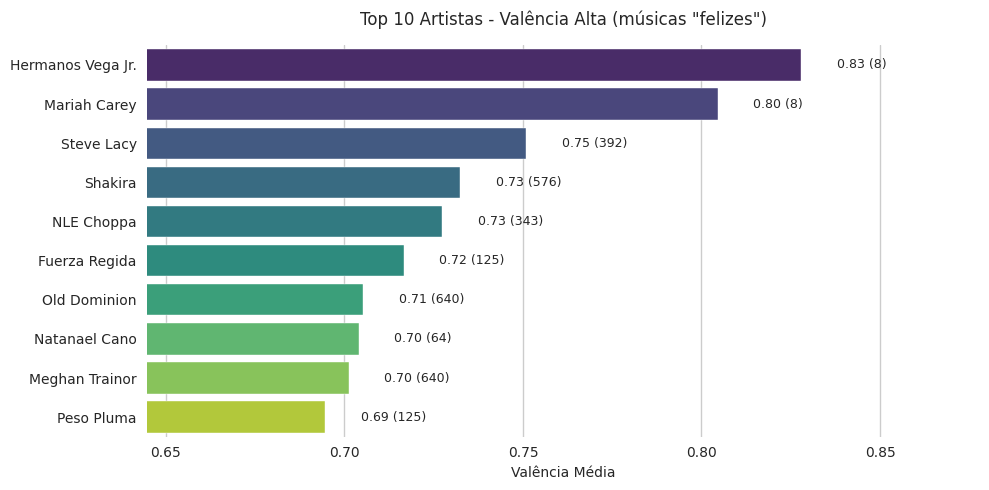

In [0]:
# Consulta SQL
happy_artists = spark.sql("""
    SELECT 
        a.nome_artista,
        AVG(f.Valence) as avg_valence,
        COUNT(*) as num_musicas
    FROM billboard_db.fato_musica_billboard f
    JOIN billboard_db.dim_artista a ON f.id_artista = a.id_artista
    GROUP BY a.nome_artista
    HAVING COUNT(*) >= 5
    ORDER BY avg_valence DESC
    LIMIT 10
""").toPandas()
    
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

# Ajuste do eixo X
x_min = happy_artists['avg_valence'].min() - 0.05
x_max = happy_artists['avg_valence'].max() + 0.05

ax = sns.barplot(x='avg_valence', y='nome_artista', 
                 data=happy_artists, palette="viridis")

# Texto compacto
for i, (val, count) in enumerate(zip(happy_artists['avg_valence'], happy_artists['num_musicas'])):
    ax.text(val + 0.01, i, f"{val:.2f} ({count})",
            va='center', fontsize=9)

plt.title('Top 10 Artistas - Valência Alta (músicas "felizes")', fontsize=12, pad=15)
plt.xlabel('Valência Média', fontsize=10)
plt.ylabel('')
plt.xlim(x_min, x_max)
sns.despine(left=True)
plt.tight_layout()
plt.show()

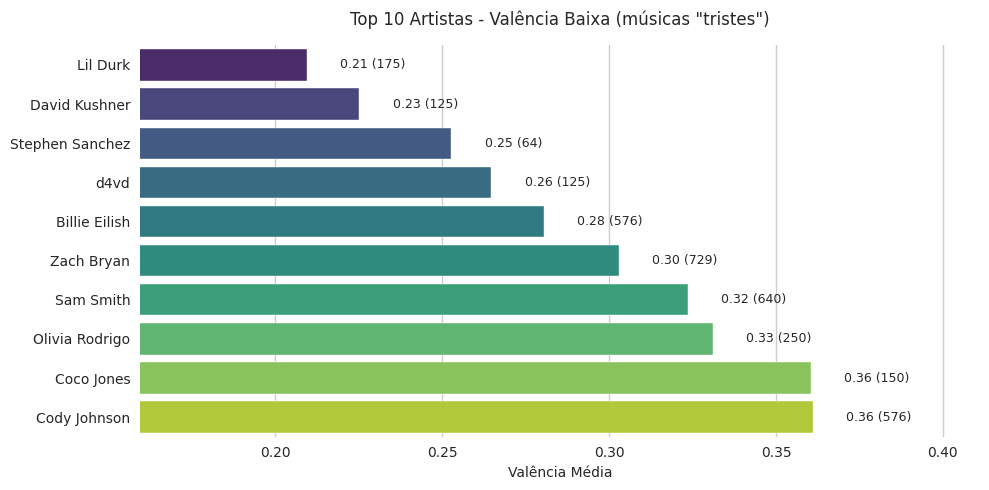

In [0]:
# Consulta SQL
sad_artists = spark.sql("""
    SELECT 
        a.nome_artista,
        AVG(f.Valence) as avg_valence,
        COUNT(*) as num_musicas
    FROM billboard_db.fato_musica_billboard f
    JOIN billboard_db.dim_artista a ON f.id_artista = a.id_artista
    GROUP BY a.nome_artista
    HAVING COUNT(*) >= 5 
    ORDER BY avg_valence ASC
    LIMIT 10
""").toPandas()

plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

# Ajuste do eixo X
x_min = sad_artists['avg_valence'].min() - 0.05
x_max = sad_artists['avg_valence'].max() + 0.05

ax = sns.barplot(x='avg_valence', y='nome_artista', 
                 data=sad_artists, palette="viridis")

for i, (val, count) in enumerate(zip(sad_artists['avg_valence'], sad_artists['num_musicas'])):
    ax.text(val + 0.01, i, f"{val:.2f} ({count})", 
            va='center', fontsize=9)

plt.title('Top 10 Artistas - Valência Baixa (músicas "tristes")', fontsize=12, pad=15)
plt.xlabel('Valência Média', fontsize=10)
plt.ylabel('')
plt.xlim(x_min, x_max)
sns.despine(left=True)
plt.tight_layout()
plt.show()

##### 6. Há tendências claras na duração das músicas ao longo dos anos?

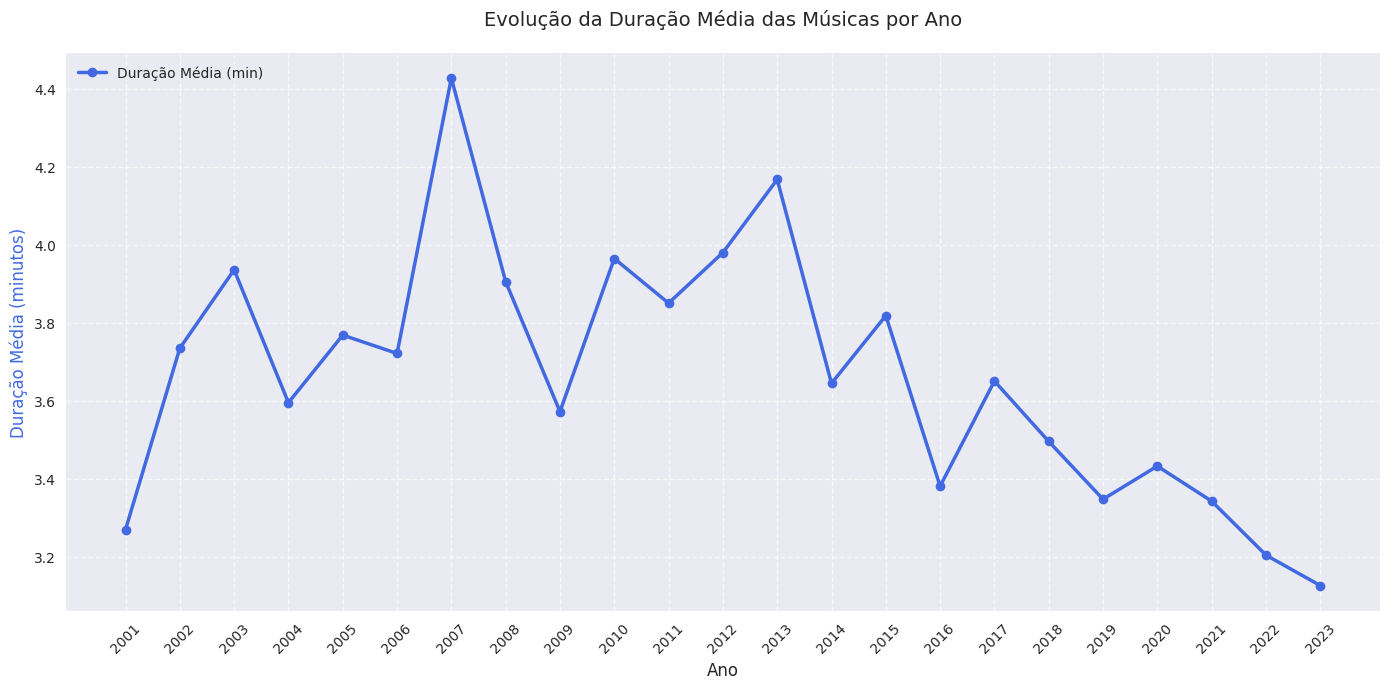

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Executar a consulta SQL e converter para DataFrame
duration_df = spark.sql("""
    SELECT 
        t.ano,
        AVG(f.duration_ms / 60000) as avg_duration_minutes
    FROM billboard_db.fato_musica_billboard f
    JOIN billboard_db.dim_tempo t ON f.id_tempo = t.id_tempo
    GROUP BY t.ano
    ORDER BY t.ano
""").toPandas()

# Configuração do estilo
plt.style.use('seaborn')
plt.figure(figsize=(14, 7))

# Gráfico de linha para duração média
plt.plot(duration_df['ano'], duration_df['avg_duration_minutes'], 
         color='royalblue', marker='o', linewidth=2.5, label='Duração Média (min)')

plt.xlabel('Ano', fontsize=12)
plt.ylabel('Duração Média (minutos)', fontsize=12, color='royalblue')
plt.grid(True, linestyle='--', alpha=0.7)

# Adicionar título e legenda
plt.title('Evolução da Duração Média das Músicas por Ano', fontsize=14, pad=20)
plt.legend(loc='upper left', fontsize=10)

# Melhorar a exibição dos anos no eixo X
plt.xticks(duration_df['ano'], rotation=45)

plt.tight_layout()
plt.show()

**Queda na Duração:**

Pode-se observar que entre 2001 e 2017 há uma grande variação e a partir disso uma diminuição gradual que pode estar associada ao impacto das plataformas de _streaming_, onde as faixas mais curtas são favorecidas, pois aumentam tanto a retenção quanto os _streams_ repetidos.

## Discussão

### Conclusão

O dataset revela tendências importantes sobre a evolução da música popular:

- As músicas estão ficando mais dançantes e energéticas, mas a positividade emocional pode estar caindo.
- Músicas mais acústicas têm leve vantagem na popularidade, enquanto músicas muito faladas são menos populares.
- A duração das músicas vem diminuindo, adaptando-se ao consumo digital.
- Não há uma única característica que garanta sucesso, mas a combinação de fatores pode influenciar a posição nas paradas.

### Autoavaliação

Neste projeto, meu objetivo foi explorar a evolução das tendências musicais ao longo de mais de duas décadas, utilizando dados do Billboard Hot 100 e métricas do Spotify. 

Consegui expor como características como danceability, energy e valence variaram ao longo do tempo, oferecendo insights sobre mudanças na sonoridade das músicas mais populares.

No entanto, encontrei dificuldades técnicas na elaboração dos gráficos, especialmente na configuração correta da visualização dos dados.

Alguns desafios incluíram a manipulação de dados no Databricks, a conversão entre PySpark e Pandas, além de ajustes na estética e interpretação dos gráficos. Apesar disso, consegui construir uma análise coesa e visualmente compreensível.

Para aprimorar este trabalho, pretendo:
- Incluir mais fontes de dados, cruzando informações de diferentes plataformas.
- Buscar referências de trabalhos acadêmicos e estudos semelhantes, para validar e aprofundar a análise.
- Aprimorar a visualização de dados, explorando técnicas mais avançadas para tornar as tendências ainda mais evidentes.

De forma geral, considero que o projeto atingiu seus objetivos principais, mas ainda há espaço para melhorias.